# Import

In [2]:
import os
import re
from decimal import Decimal, ROUND_HALF_UP
from datetime import datetime as dt
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgbm
import xgboost as xgb

import joblib
from sklearn.metrics import mean_squared_error

import pandas_profiling as pdp

import warnings
warnings.filterwarnings('ignore')

In [3]:
# XXXXを任意のディレクトリやファイル名に書き換える

# train/testのディレクトリ
INPUT_DIR = './input'
# model/submissionの出力先
OUTPUT_DIR = './output'

# ファイル名
MODEL_NAME = 'first_commit'
CSV_NAME = 'first_commit'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# データ読み込み

In [4]:
# データ読み込み
train = pd.read_csv(f'{INPUT_DIR}/train.csv')
test = pd.read_csv(f'{INPUT_DIR}/test.csv', index_col='id')
df = pd.concat([train, test], ignore_index=True)
df.reset_index(drop=True, inplace=True)

# 前処理

In [5]:

def logy(x):
  return np.log1p(x)

# descriptionをざっくりカウント
def description_counts(x):
  return int(Decimal(len(x.split(' '))).quantize(Decimal('1E2'), rounding=ROUND_HALF_UP))

# nameをざっくりカウント
def name_counts(x):
  return int(Decimal(len(x)).quantize(Decimal('1E1'), rounding=ROUND_HALF_UP))

# review_scores_ratingを非線形処理
def review_total_score(x):
  if np.isnan(x):
    return None
  return int(Decimal(x).quantize(Decimal('1E3'), rounding=ROUND_HALF_UP))

# 閾値以下の出現率を'Other'に置き換える
def cut_under_counts(df, thd_percent=1):
  cut_idx = df.value_counts() / len(df) * 100
  for cut_type, percent in zip(cut_idx.index, cut_idx.values):
    if percent < thd_percent:
      df[df == cut_type] = 'Other'
  print(df.value_counts() / len(df) * 100)
  return df

# Label Encoding
def LE(df, target_col, rm_cols=None, num_cols=None):
  features = [
      f for f in df.columns if f not in (target_col, rm_cols)
      and f not in num_cols
              ]
  for col in features:
      if col not in num_cols:
        df.loc[:, col] = df[col].astype(str).fillna('NONE')
        le = LabelEncoder()
        le.fit(df[col])
        df.loc[:, col] = le.transform(df[col])
  return df

In [6]:
#別で作ったamenityの読み込み＆結合
import pickle
with open('./output/amenities.pickle', 'rb') as f:
   amenities_onehot = pickle.load(f)
df = pd.concat([df, amenities_onehot], axis = 1)

In [7]:
# 前処理&特徴量エンジニアリング
def make_feat(df):
  df['host_since'] = pd.to_datetime(df['host_since'])
  df['last_review'] = pd.to_datetime(df['last_review'])
  df['first_review'] = pd.to_datetime(df['first_review'])
  
  df['y'] = df['y'].apply(lambda x: logy(x))
  
  df['name'] = df['name'].apply(lambda x: name_counts(x))
  df['host_since'] = df['host_since'].apply(lambda x: timedelta_hostsince(x))
  df['last_review'] = df['last_review'].apply(lambda x: timedelta_lastreview(x))
  df['first_review'] = df['first_review'].apply(lambda x: timedelta_firstreview(x))
  df['description'] = df['description'].apply(lambda x: description_counts(x))
  df['review_scores_rating'] = df['review_scores_rating'].apply(lambda x: review_total_score(x))
  df['bedrooms_and_bathrooms'] = df['bathrooms'] + df['bedrooms']
  df['bedrooms_and_beds'] = df['bedrooms'] + df['beds']
  df['bathrooms_and_beds'] = df['bathrooms'] + df['beds']
  df['accommodates_and_beds'] = df['accommodates'] + df['beds']
  df['property_type'] = cut_under_counts(df['property_type'], thd_percent=0.5)
  df['neighbourhood'] = cut_under_counts(df['neighbourhood'], thd_percent=0.5)

make_feat(df)
target_col = 'y'

# 除外する特徴量
rm_cols = [
    'amenities'
]

# 数量データ
num_cols = [
    col for col in df.drop(['y']+rm_cols, axis=1).columns if df[col].dtype != object
]

df = LE(df, target_col, rm_cols, num_cols)
df.head()

Apartment          66.121089
House              22.278744
Condominium         3.586512
Other               2.756676
Townhouse           2.283062
Loft                1.678563
Guesthouse          0.671965
Bed & Breakfast     0.623389
Name: property_type, dtype: float64
Other                    44.840847
Williamsburg              3.861775
Bedford-Stuyvesant        2.922643
Bushwick                  2.160273
Upper West Side           1.883661
Mid-Wilshire              1.878264
Harlem                    1.853976
Hollywood                 1.782461
Hell's Kitchen            1.752776
Venice                    1.648878
Upper East Side           1.627289
Crown Heights             1.451876
Astoria                   1.211696
Lower East Side           1.123990
East Village              1.098352
East Harlem               1.070017
Mission District          1.057873
West Hollywood            0.983660
Chelsea                   0.979612
Greenpoint                0.978262
Washington Heights        0.9742

,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,...,153,154,155,156,157,158,bedrooms_and_bathrooms,bedrooms_and_beds,bathrooms_and_beds,accommodates_and_beds
0,0.0,6,50990,2.0,4,1.0,4.0,0,3,1,...,0,0,0,0,0,0,3.0,5.0,6.0,10.0
1,1.0,2,30419,1.0,4,1.0,1.0,2,2,1,...,0,0,0,0,0,0,2.0,2.0,2.0,3.0
2,2.0,2,65377,2.0,4,1.0,1.0,2,4,1,...,0,0,0,0,0,0,3.0,2.0,3.0,3.0
3,3.0,2,26678,1.0,4,1.0,1.0,2,5,1,...,0,0,0,0,0,0,2.0,2.0,2.0,3.0
4,4.0,2,60883,1.0,4,1.0,1.0,2,4,1,...,0,0,0,0,0,0,2.0,2.0,2.0,3.0


In [8]:
# 欠損値の確認
# LightGBMを使うので今回はそのまま学習させる
df.isnull().sum()

id                        18528
accommodates                  0
amenities                     0
bathrooms                   200
bed_type                      0
                          ...  
158                           0
bedrooms_and_bathrooms      286
bedrooms_and_beds           193
bathrooms_and_beds          285
accommodates_and_beds       131
Length: 192, dtype: int64

# Train

In [9]:
train_X, train_y = df.loc[~df['y'].isna(), :].drop('y', axis=1), df.loc[~df['y'].isna(), ['y']]
test_X = df.loc[df['y'].isna(), :].drop('y', axis=1)
print(f'train_X:{train_X.shape}, train_y:{train_y.shape}')
print(f'test_X:{test_X.shape}')

train_X:(55583, 191), train_y:(55583, 1)
test_X:(18528, 191)


In [10]:
# LightGBM パラメータ

lgbm_params = {
    'learning_rate': 0.01,
    'objective': 'regression',
    'metrics': 'rmse',
    'random_seed': 1234,
    'n_jobs': -1,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'seed':1,
  }
'''
lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 15,
    "num_iterations":150,
    'learning_rate': 0.03,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'seed':1,
}
'''

'\nlgbm_params = {\n    \'boosting_type\': \'gbdt\',\n    \'objective\': \'regression\',\n    \'metric\': \'rmse\',\n    \'num_leaves\': 15,\n    "num_iterations":150,\n    \'learning_rate\': 0.03,\n    \'bagging_fraction\': 0.8,\n    \'bagging_freq\': 1,\n    \'seed\':1,\n}\n'

In [11]:
# KFoldもいろいろ変えてみるといいかも
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1234)

In [12]:
# LightGBM
import optuna.integration.lightgbm as lgb

models = []
rmses = []
for fold, (train_index, val_index) in enumerate(kf.split(train_X)):
  print(f'fold:{fold:02d} start')
  X_train = train_X.iloc[train_index]
  X_valid = train_X.iloc[val_index]
  y_train = train_y.iloc[train_index]
  y_valid = train_y.iloc[val_index]

  lgb_train = lgbm.Dataset(X_train, y_train)
  lgb_eval = lgbm.Dataset(X_valid, y_valid, reference=lgb_train)

  model_lgb = lgbm.train(lgbm_params,
                        lgb_train,
                        valid_sets = lgb_eval,
                        num_boost_round = 10000,
                        early_stopping_rounds = 1000,
                        verbose_eval = 100,
                        )
  
  y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
  tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

  models.append(model_lgb)
  rmses.append(tmp_rmse)

fold:00 start
[LightGBM] [Warning] seed is set=1, random_seed=1234 will be ignored. Current value: seed=1
[LightGBM] [Warning] seed is set=1, random_seed=1234 will be ignored. Current value: seed=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3143
[LightGBM] [Info] Number of data points in the train set: 44466, number of used features: 161
[LightGBM] [Warning] seed is set=1, random_seed=1234 will be ignored. Current value: seed=1
[LightGBM] [Info] Start training from score 4.792954
Training until validation scores don't improve for 1000 rounds
[100]	valid_0's rmse: 0.481854
[200]	valid_0's rmse: 0.425888
[300]	valid_0's rmse: 0.405163
[400]	valid_0's rmse: 0.392923
[500]	valid_0's rmse: 0.384967
[600]	valid_0's rmse: 0.380092
[700]	valid_0's rmse: 0.376972
[800]	valid_0's rmse

In [13]:
# CV
sum(rmses)/len(rmses)

0.36463831239570005

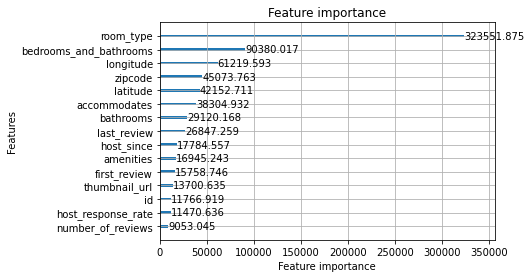

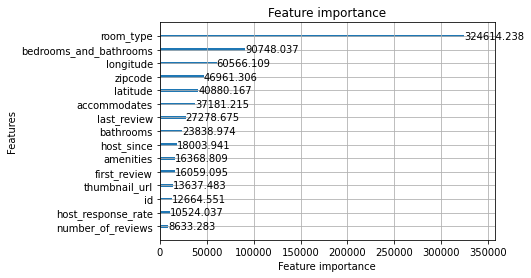

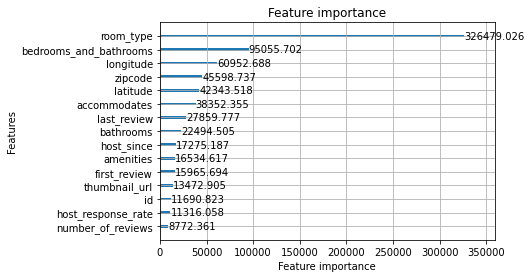

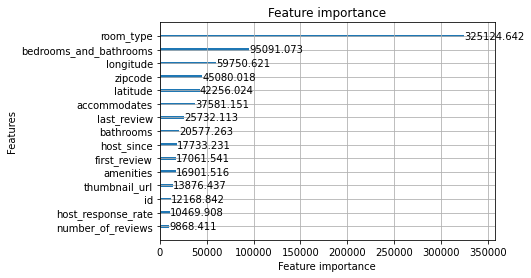

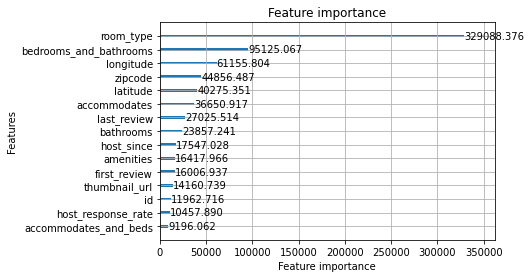

In [14]:
# Feature Importance
for model in models:
  lgbm.plot_importance(model,importance_type='gain',max_num_features=15)

# Predict

In [15]:
preds = []
for i, model in enumerate(models):
  # modelの保存
  joblib.dump(model, f'{OUTPUT_DIR}/{MODEL_NAME}_{i:02d}.pkl')
  # Predict
  pred = model.predict(test_X, num_iteration=model.best_iteration)
  preds.append(pred)

preds_array = np.array(preds)
preds_mean = np.mean(preds_array,axis=0)

# submitの作成
sample_submit = pd.read_csv(f'{INPUT_DIR}/sample_submit.csv', header=None)
sample_submit.head()

sample_submit[1] = preds_mean
sample_submit.head()

sample_submit.to_csv(f'{OUTPUT_DIR}/{CSV_NAME}.csv', index=False, header=False)

In [17]:
import math
out = math.e**preds_mean

In [19]:

# submitの作成
sample_submit = pd.read_csv(f'{INPUT_DIR}/sample_submit.csv', header=None)
sample_submit.head()

sample_submit[1] = out
sample_submit.head()

sample_submit.to_csv(f'{OUTPUT_DIR}/logy.csv', index=False, header=False)